# Chapter 04 - Cell Ranger Filtered UMAP

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


In [1]:
%load_ext autoreload
%autoreload 2

## Core Imports

In [2]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List, Union
import utils
import infercnvpy as cnv

## File Paths and Metadata

In [3]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = "./figures/chapter_05_cell_ranger_filtered_cell_typing"
RAW_FEATURE_BC_MATRIX_FILE_NAME = "raw_feature_bc_matrix.h5"

# Make sure figures output directory exists
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")
GTF_FILE_NAME = "Homo_sapiens.GRCh38.114.gtf.gz"
INPUT_ADATA_DIR = os.path.join(
    DATA_DIR, "adatas", "combined_adatas_filtered_cells_clusters_removed"
)
OUTPUT_ADATA_DIR = os.path.join(
    DATA_DIR,
    "adatas",
    "combined_adatas_filtered_cells_clusters_removed_with_cell_type",
)

# Make sure output adata dir directory exists
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

## Read in AnnDatas

In [4]:
adata_tissues = []

for _, (_, tissue, _) in samples.items():
    if tissue not in adata_tissues:
        adata_tissues.append(tissue)

combined_by_tissue = {}
for tissue in adata_tissues:
    file_path = os.path.join(
        INPUT_ADATA_DIR,
        f"{tissue.replace(' ', '_')}_combined_adata_clusters_removed.h5ad",
    )
    if os.path.exists(file_path):
        adata = sc.read_h5ad(file_path)
        combined_by_tissue[tissue] = adata
        print(f"Loaded combined AnnData for {tissue} from {file_path}")
        print(f"{tissue} AnnData: {adata}")
    else:
        raise FileNotFoundError(
            f"Combined AnnData for {tissue} not found at {file_path}. Skipping."
        )

Loaded combined AnnData for Normal Colon from ./data/adatas/combined_adatas_filtered_cells_clusters_removed/Normal_Colon_combined_adata_clusters_removed.h5ad
Normal Colon AnnData: AnnData object with n_obs × n_vars = 11247 × 18667
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'doublet_score', 'predicted_doublet', 'protocol', 'tissue', 'sample', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'downsampled_umi', 'raw_data'
    obsp: 'connectivities', 'distances'
Loaded combined AnnData for Tumor Colon from ./data/adatas/co

## Cell Typing

### Normal Liver

#### CellTypist

🔬 Input data has 13315 cells and 19719 genes
🔗 Matching reference genes in the model
🧬 2279 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


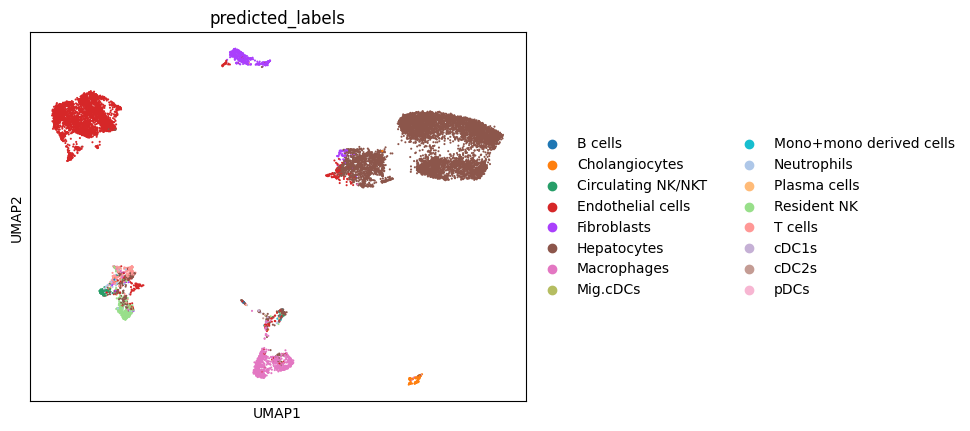

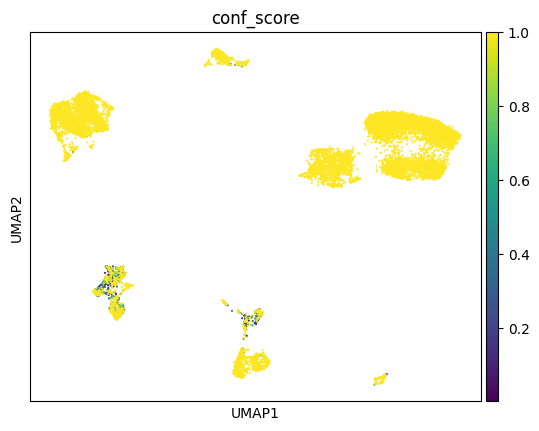

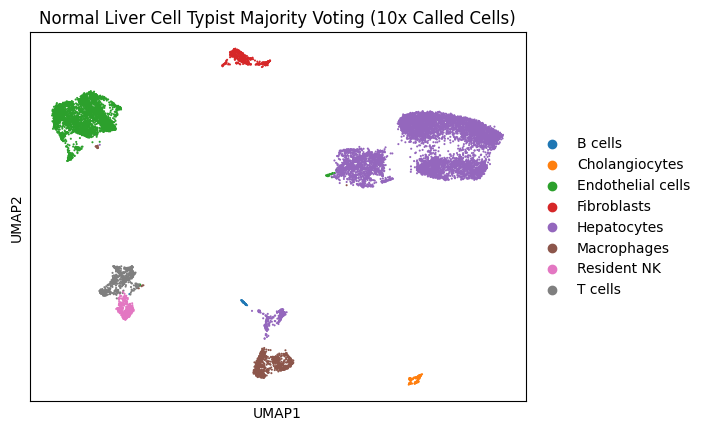

In [5]:
import celltypist

normal_liver_cell_typist_input = combined_by_tissue["Normal Liver"].copy()
normal_liver_cell_typist_input.X = normal_liver_cell_typist_input.layers[
    "raw_data"
].copy()
sc.pp.normalize_total(normal_liver_cell_typist_input, target_sum=1e4, inplace=True)
sc.pp.log1p(normal_liver_cell_typist_input)

liver_cell_predictions = celltypist.annotate(
    normal_liver_cell_typist_input,
    model="Healthy_Human_Liver.pkl",
    majority_voting=True,
    over_clustering="leiden",
)

liver_cell_predictions_adata = liver_cell_predictions.to_adata()

majority_voting_output_path = os.path.join(
    FIGURES_OUTPUT_DIR, "majority_voting_output.png"
)

sc.pl.umap(liver_cell_predictions_adata, color="predicted_labels")
sc.pl.umap(liver_cell_predictions_adata, color="conf_score")
fig = sc.pl.umap(
    liver_cell_predictions_adata,
    color="majority_voting",
    title="Normal Liver Cell Typist Majority Voting (10x Called Cells)",
    return_fig=True,
)
fig.savefig(majority_voting_output_path, bbox_inches="tight")

#### Marker Genes

In [6]:
def filter_marker_genes_by_adata(marker_dict: dict, adata: sc.AnnData) -> dict:
    """
    Filters a marker gene dictionary to include only genes present in adata.var_names.

    Args:
        marker_dict: Dictionary mapping cell types to lists of marker genes.
        adata: AnnData object whose var_names will be used to filter genes.

    Returns:
        A new dictionary with only valid genes per cell type.
    """
    valid_genes = set(adata.var_names)
    filtered_dict = {
        celltype: [gene for gene in genes if gene in valid_genes]
        for celltype, genes in marker_dict.items()
    }
    return filtered_dict

In [7]:
liver_marker_dict = {
    "Hepatocytes": [
        "APOB",
        "CYP3A4",
    ],  # https://www.nature.com/articles/s42003-022-04046-9
    "Cholangiocytes": [
        "KRT19",
        "CFTR",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC4315871/
    "Endothelial cells": [
        "PECAM1",
        "CDH5",
        "LDB2",
        "PTPRB",
    ],  # https://www.nature.com/articles/s41467-022-30633-9, CELL x GENE
    "Fibroblasts": [
        "COL1A2",
        "COL5A2",
        "COL6A3",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC7444611/, CELL x Gene
    "Macrophages": [
        "CD68",
        "C1QA",
        "C1QB",
        "C1QC",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC10153153/, https://pmc.ncbi.nlm.nih.gov/articles/PMC10849641/
    "Resident NK": [
        "KLRD1",
        "NCAM1",
    ],  # https://www.ncbi.nlm.nih.gov/gene/3824, https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2017.00892/full
    "T cells": [
        "CD3D",
        "CD3E",
        "CD3G",
        "CD2",
    ],  # https://pubmed.ncbi.nlm.nih.gov/39029632/
    "B cells": [
        "BANK1",
        "IGHM",
        "CD19",
        "CD20",
    ],  # BANK1 (B cell scaffold protein), IGHMis part of B cell receptor (IgM), CD19 and CD20 were not expressed in enough cells and were filtered out
    # # "B cells": ["CD19", "CD79A", "CD79B"], # https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02064-6?utm_source=chatgpt.com
}

#### Plot Dotplot

dendrogram data not found (using key=dendrogram_majority_voting). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


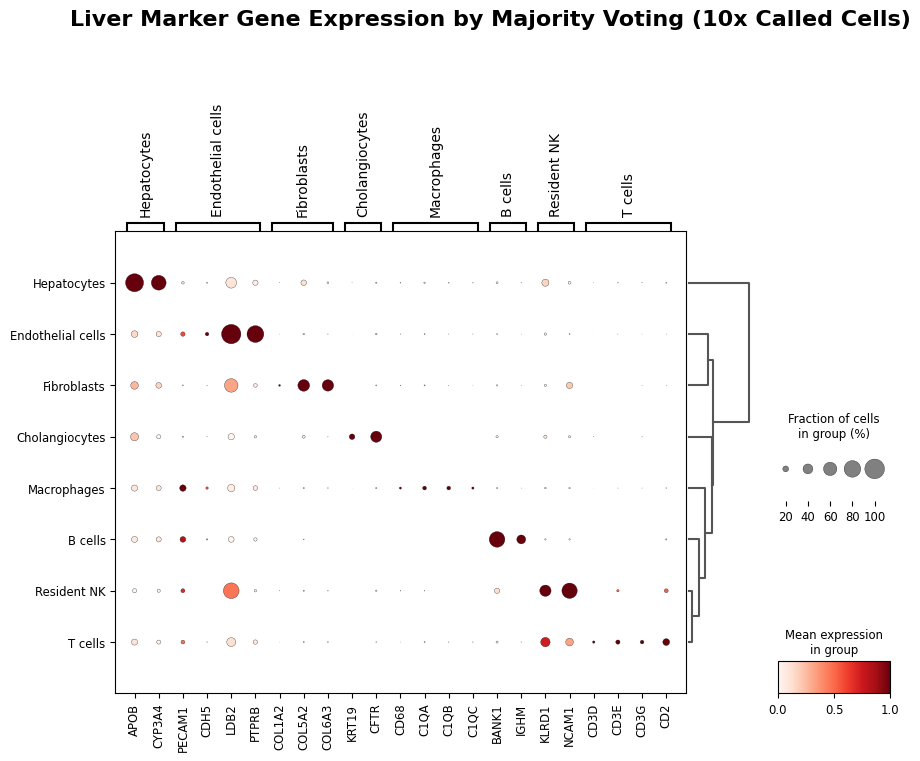

In [8]:
filtered_liver_marker_dict = filter_marker_genes_by_adata(
    marker_dict=liver_marker_dict,
    adata=combined_by_tissue["Normal Liver"],
)

# Create the dotplot
liver_dp = sc.pl.dotplot(
    liver_cell_predictions_adata,
    var_names=filtered_liver_marker_dict,
    groupby="majority_voting",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = liver_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting (10x Called Cells)",
    fontsize=16,
    weight="bold",
    y=1.25,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_dotplot.png"))

#### Plot Heatmap

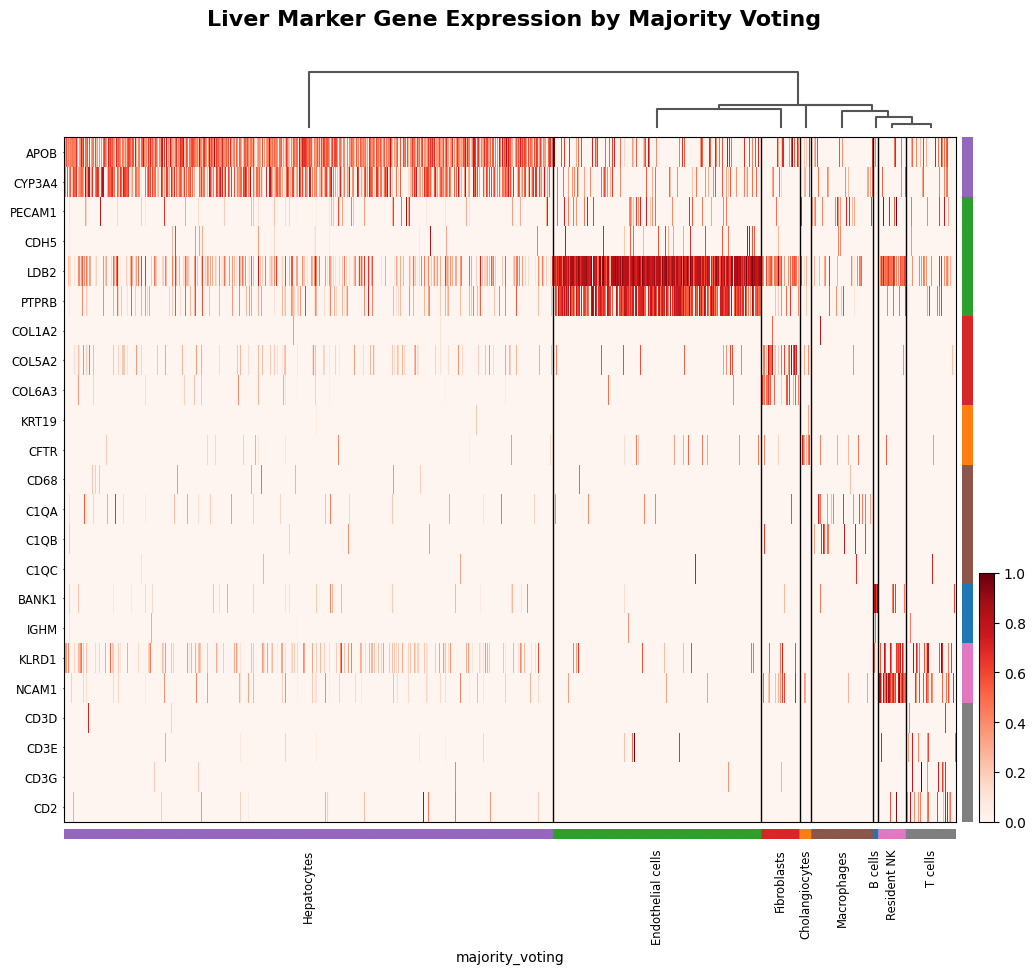

In [9]:
# Create and store the heatmap object
liver_hm = sc.pl.heatmap(
    liver_cell_predictions_adata,
    var_names=filtered_liver_marker_dict,
    groupby="majority_voting",
    use_raw=False,
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_rotation=90,
    var_group_labels=liver_marker_dict.keys(),
    dendrogram=True,
    figsize=(12, 10),
    show=False,
)

# Use any axis to get the figure
fig = next(iter(liver_hm.values())).figure

# Set suptitle and adjust layout
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting",
    fontsize=16,
    weight="bold",
    y=0.94,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_heatmap.png"),
    bbox_inches="tight",
)

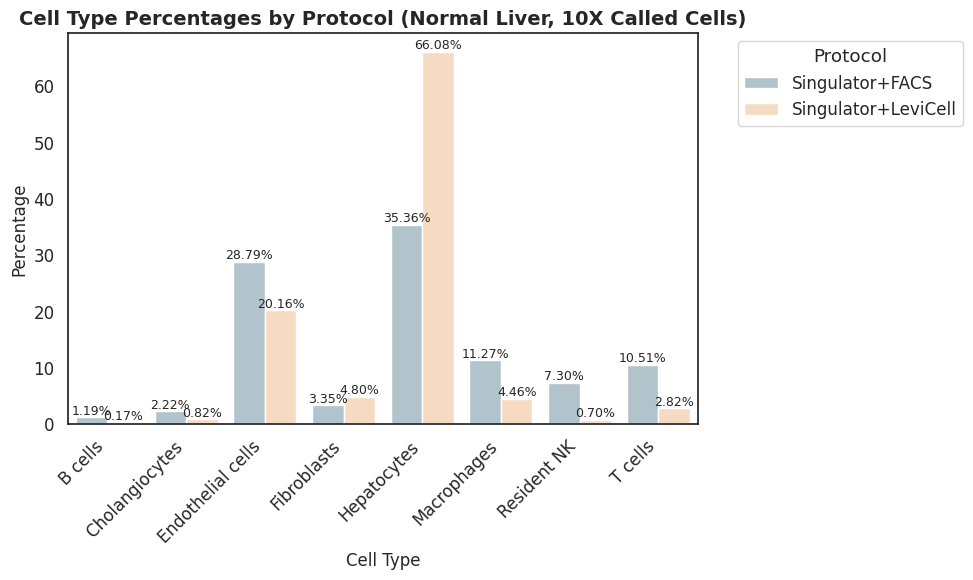

In [10]:
# Plot cell type proportions by protocol for Normal Liver
fig = utils.plot_celltype_proportions_by_protocol(
    adata=liver_cell_predictions_adata,
    tissue="Normal Liver",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    percentage=True,
    title="Cell Type Percentages by Protocol (Normal Liver, 10X Called Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_cell_type_proportions.png"),
    bbox_inches="tight",
)

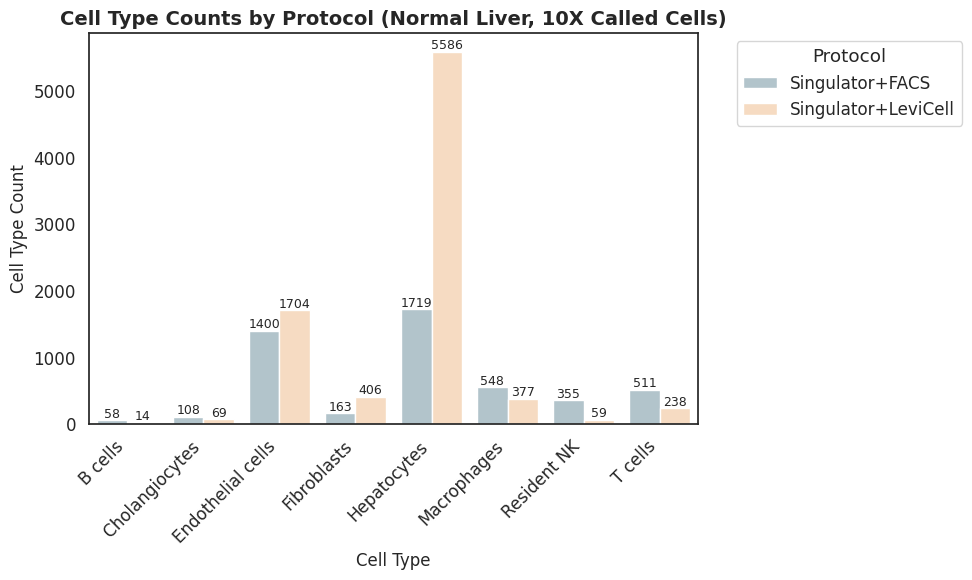

In [11]:
# Plot cell type proportions by protocol for Normal Liver
fig = utils.plot_celltype_proportions_by_protocol(
    adata=liver_cell_predictions_adata,
    tissue="Normal Liver",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    percentage=False,
    title="Cell Type Counts by Protocol (Normal Liver, 10X Called Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_cell_type_proportions.png"),
    bbox_inches="tight",
)

#### Add annotations to original AnnData

In [12]:
# Add annotations to original AnnData without a method

combined_by_tissue["Normal Liver"].obs["predicted_cell_type"] = (
    liver_cell_predictions_adata.obs["majority_voting"]
)

### Normal Colon

#### Functions

In [13]:
def assign_celltypes_by_cluster_avg_expression(
    adata: sc.AnnData,
    cell_marker_genes: dict,
    cluster_key: str = "leiden",
) -> None:
    """
    Assigns a cell type to each cluster based on average expression of marker genes.

    Args:
        adata: Annotated data matrix (AnnData object).
        cell_marker_genes: Dict mapping cell types to marker gene lists.
        cluster_key: Key in `adata.obs` corresponding to cluster labels (e.g., 'leiden').

    Modifies:
        adata.obs["predicted_cell_type"]: Cluster-level cell type assignment.
    """
    # Set data matrix
    expr = adata.X
    gene_names = adata.var_names

    # Compute cluster-wise average expression
    clusters = adata.obs[cluster_key].astype(str)
    cluster_names = clusters.unique()

    cluster_means = []
    for cluster in cluster_names:
        idx = (clusters == cluster).values  # convert to NumPy array for sparse indexing
        avg_expr = np.asarray(expr[idx].mean(axis=0)).flatten()
        cluster_means.append(avg_expr)

    cluster_means = pd.DataFrame(
        cluster_means,
        index=cluster_names,
        columns=gene_names,
    )

    # Score each cluster for each cell type
    scores = {}
    for cell_type, markers in cell_marker_genes.items():
        valid_genes = [g for g in markers if g in cluster_means.columns]
        if not valid_genes:
            continue
        scores[cell_type] = cluster_means[valid_genes].mean(axis=1)

    scores_df = pd.DataFrame(scores)
    predicted = scores_df.idxmax(axis=1)

    # Map prediction back to each cell
    adata.obs["predicted_cell_type"] = clusters.map(predicted)

    return

In [14]:
colon_marker_dict = {
    "Epithelial": ["EPCAM", "KRT8", "KRT18"],
    "Stromal": ["COL6A2", "COL6A1", "PLVAP", "COL1A1"],
    "Immune": [
        "PTPRC",
        "CD3E",
        "CD2",
        "CD3D",
        "CD3G",
        "FCER1G",
        "CSF1R",
        "CD14",
        "CD68",
        "CD38",
    ],
}

... storing 'predicted_cell_type' as categorical


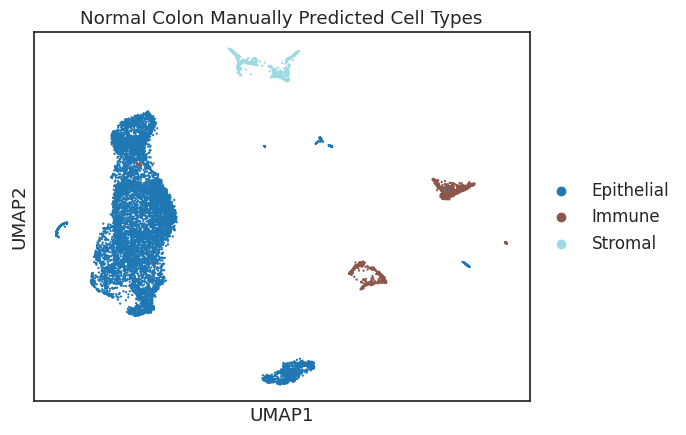

In [15]:
# Assign cell types to the colon adata
assign_celltypes_by_cluster_avg_expression(
    adata=combined_by_tissue["Normal Colon"],
    cell_marker_genes=colon_marker_dict,
    cluster_key="leiden",
)

# Plot UMAP with predicted cell types for Normal Colon
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="predicted_cell_type",
    title="Normal Colon Manually Predicted Cell Types",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
)

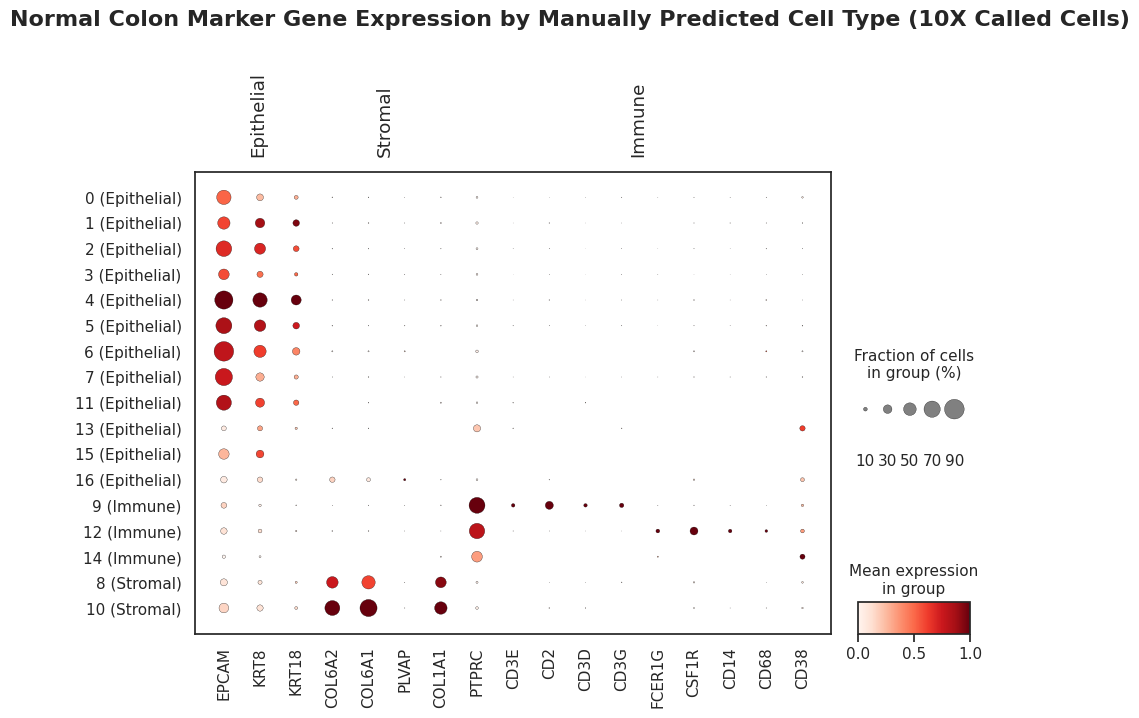

In [16]:
normal_colon_adata = combined_by_tissue["Normal Colon"].copy()
normal_colon_adata.obs["leiden_cell_type"] = (
    normal_colon_adata.obs["leiden"].astype(str)
    + " ("
    + normal_colon_adata.obs["predicted_cell_type"].astype(str)
    + ")"
)


# Sort categories by cell type first, then by leading numeral
def sort_key(cat_name):
    leiden_num = int(cat_name.split(" (")[0])
    cell_type = cat_name.split(" (")[1].rstrip(")")
    return (cell_type, leiden_num)


current_categories = normal_colon_adata.obs["leiden_cell_type"].unique()
sorted_categories = sorted(current_categories, key=sort_key)
normal_colon_adata.obs["leiden_cell_type"] = pd.Categorical(
    normal_colon_adata.obs["leiden_cell_type"],
    categories=sorted_categories,
    ordered=True,
)

filtered_colon_marker_dict = filter_marker_genes_by_adata(
    marker_dict=colon_marker_dict,
    adata=normal_colon_adata,
)

# Create the dotplot
normal_colon_dp = sc.pl.dotplot(
    normal_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=False,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = normal_colon_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Normal Colon Marker Gene Expression by Manually Predicted Cell Type (10X Called Cells)",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_colon_marker_gene_dotplot.png"))

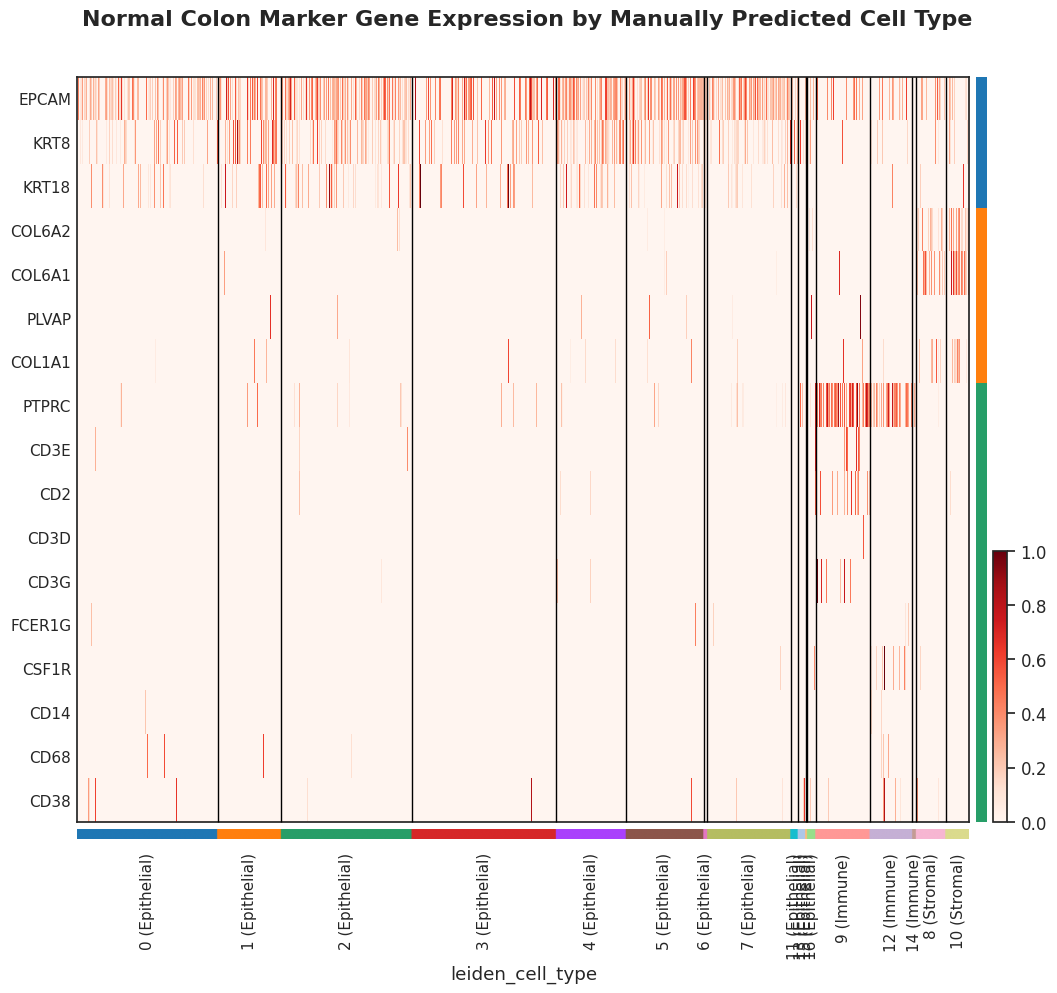

In [17]:
# Create and store the heatmap object
normal_colon_hm = sc.pl.heatmap(
    normal_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_labels=filtered_colon_marker_dict.keys(),
    var_group_rotation=45,
    dendrogram=False,
    figsize=(12, 10),
    show=False,
)

# Use any axis to get the figure
fig = next(iter(normal_colon_hm.values())).figure

# Set suptitle and adjust layout
fig.suptitle(
    "Normal Colon Marker Gene Expression by Manually Predicted Cell Type",
    fontsize=16,
    weight="bold",
    y=0.94,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "normal_colon_marker_gene_heatmap.png"),
    bbox_inches="tight",
)

#### Plot Marker Gene Expression UMAPs

### Eptithelial

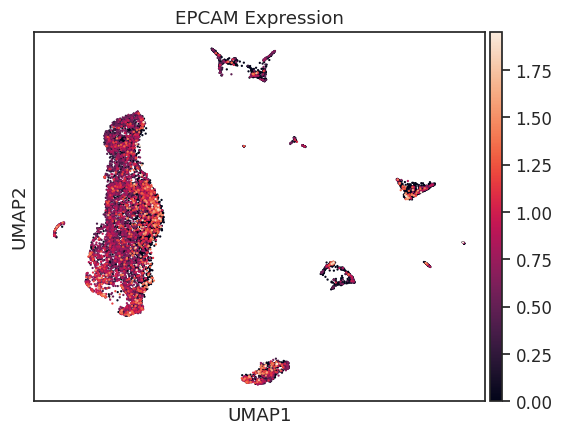

In [18]:
# Epithelial Marker (EPCAM)
sc.pl.umap(
    normal_colon_adata,
    color="EPCAM",
    title="EPCAM Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

### Immune

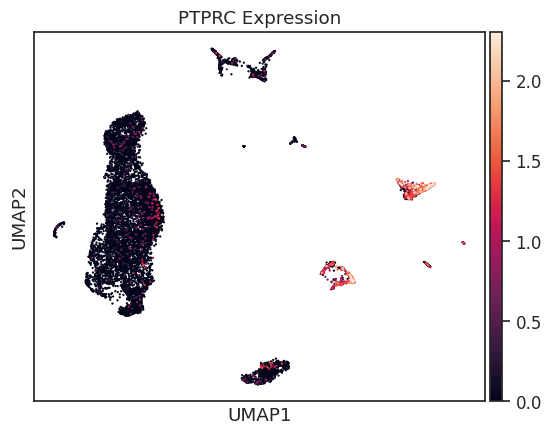

In [19]:
# Immune Marker (PTPRC)
sc.pl.umap(
    normal_colon_adata,
    color="PTPRC",
    title="PTPRC Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

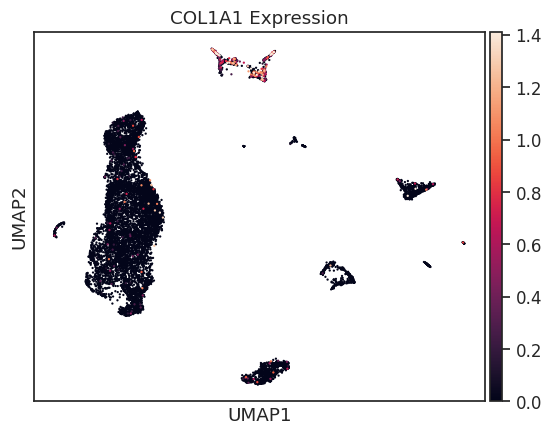

In [20]:
# Stromal Marker (COL1A1)
sc.pl.umap(
    normal_colon_adata,
    color="COL1A1",
    title="COL1A1 Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

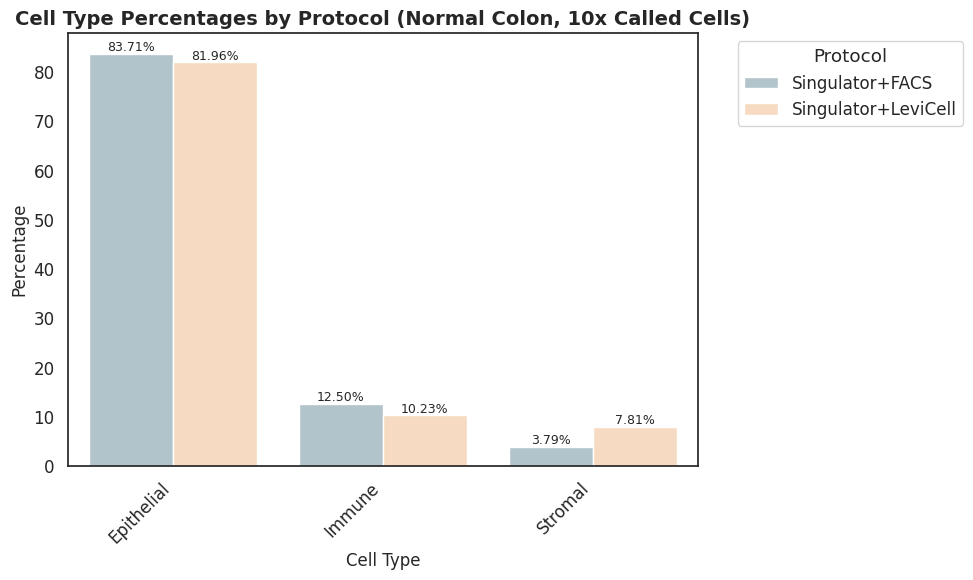

In [21]:
# Plot cell type proportions by protocol for Normal Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=normal_colon_adata,
    tissue="Normal Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="predicted_cell_type",
    percentage=True,
    title="Cell Type Percentages by Protocol (Normal Colon, 10x Called Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "normal_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

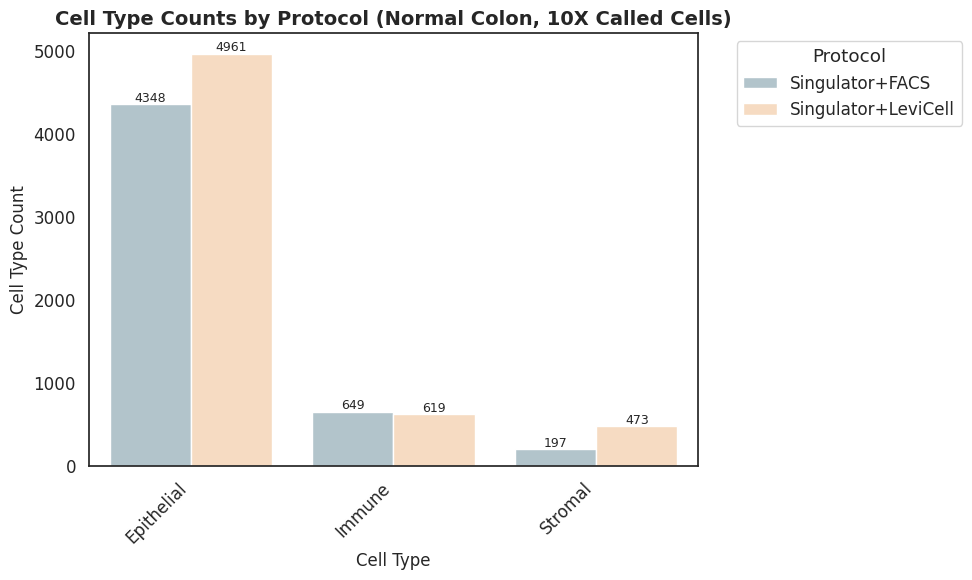

In [22]:
# Plot cell type proportions by protocol for Normal Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=normal_colon_adata,
    tissue="Normal Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="predicted_cell_type",
    percentage=False,
    title="Cell Type Counts by Protocol (Normal Colon, 10X Called Cells)"
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "normal_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

### Tumor Colon

... storing 'predicted_cell_type' as categorical


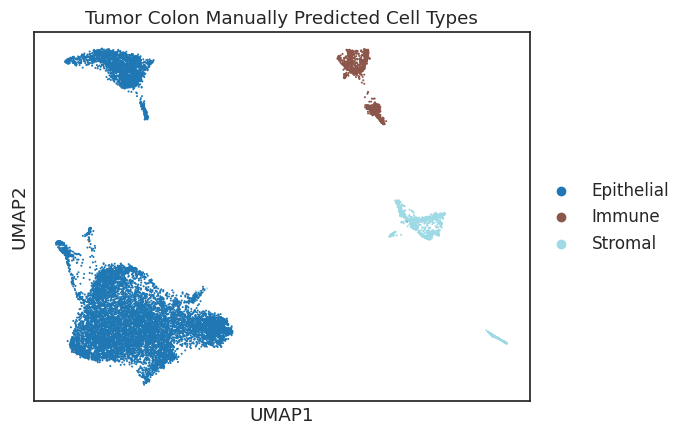

In [23]:
# Assign cell types to the colon adata
assign_celltypes_by_cluster_avg_expression(
    adata=combined_by_tissue["Tumor Colon"],
    cell_marker_genes=colon_marker_dict,
    cluster_key="leiden",
)

# Plot UMAP with predicted cell types for Tumor Colon
sc.pl.umap(
    combined_by_tissue["Tumor Colon"],
    color="predicted_cell_type",
    title="Tumor Colon Manually Predicted Cell Types",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
)

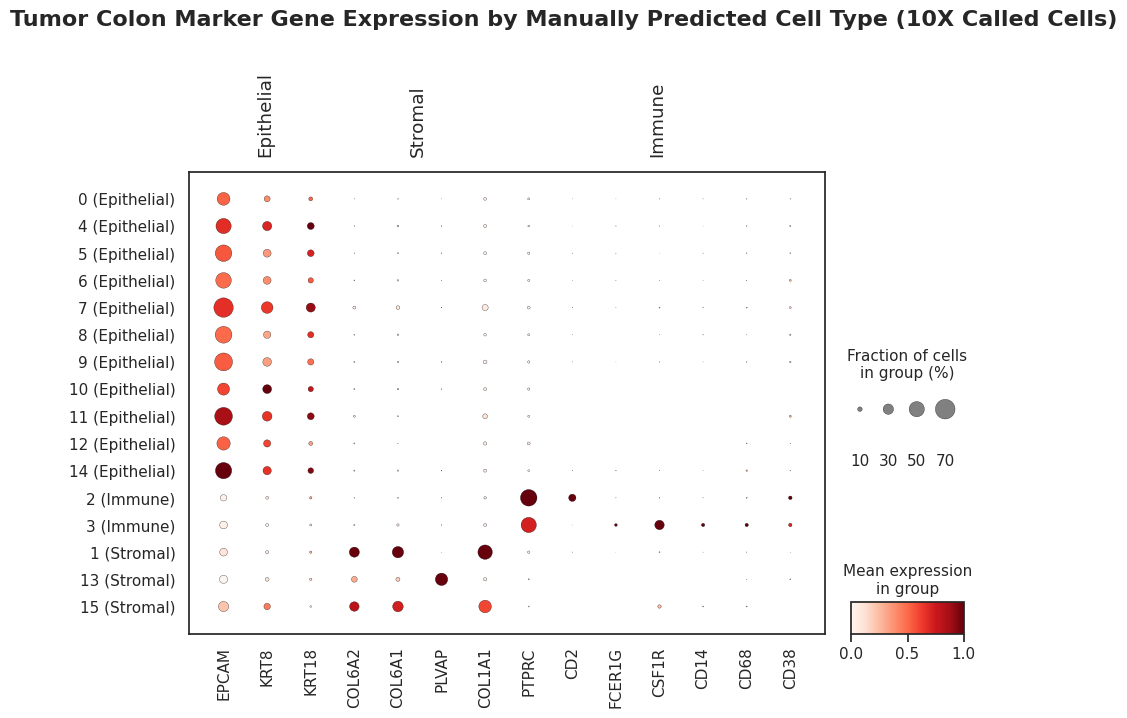

In [24]:
tumor_colon_adata = combined_by_tissue["Tumor Colon"].copy()
tumor_colon_adata.obs["leiden_cell_type"] = (
    tumor_colon_adata.obs["leiden"].astype(str)
    + " ("
    + tumor_colon_adata.obs["predicted_cell_type"].astype(str)
    + ")"
)


# Sort categories by cell type first, then by leading numeral
def sort_key(cat_name):
    leiden_num = int(cat_name.split(" (")[0])
    cell_type = cat_name.split(" (")[1].rstrip(")")
    return (cell_type, leiden_num)


current_categories = tumor_colon_adata.obs["leiden_cell_type"].unique()
sorted_categories = sorted(current_categories, key=sort_key)
tumor_colon_adata.obs["leiden_cell_type"] = pd.Categorical(
    tumor_colon_adata.obs["leiden_cell_type"],
    categories=sorted_categories,
    ordered=True,
)

filtered_colon_marker_dict = filter_marker_genes_by_adata(
    marker_dict=colon_marker_dict,
    adata=tumor_colon_adata,
)

# Create the dotplot
tumor_colon_dp = sc.pl.dotplot(
    tumor_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=False,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = tumor_colon_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Tumor Colon Marker Gene Expression by Manually Predicted Cell Type (10X Called Cells)",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_marker_gene_dotplot.png"))

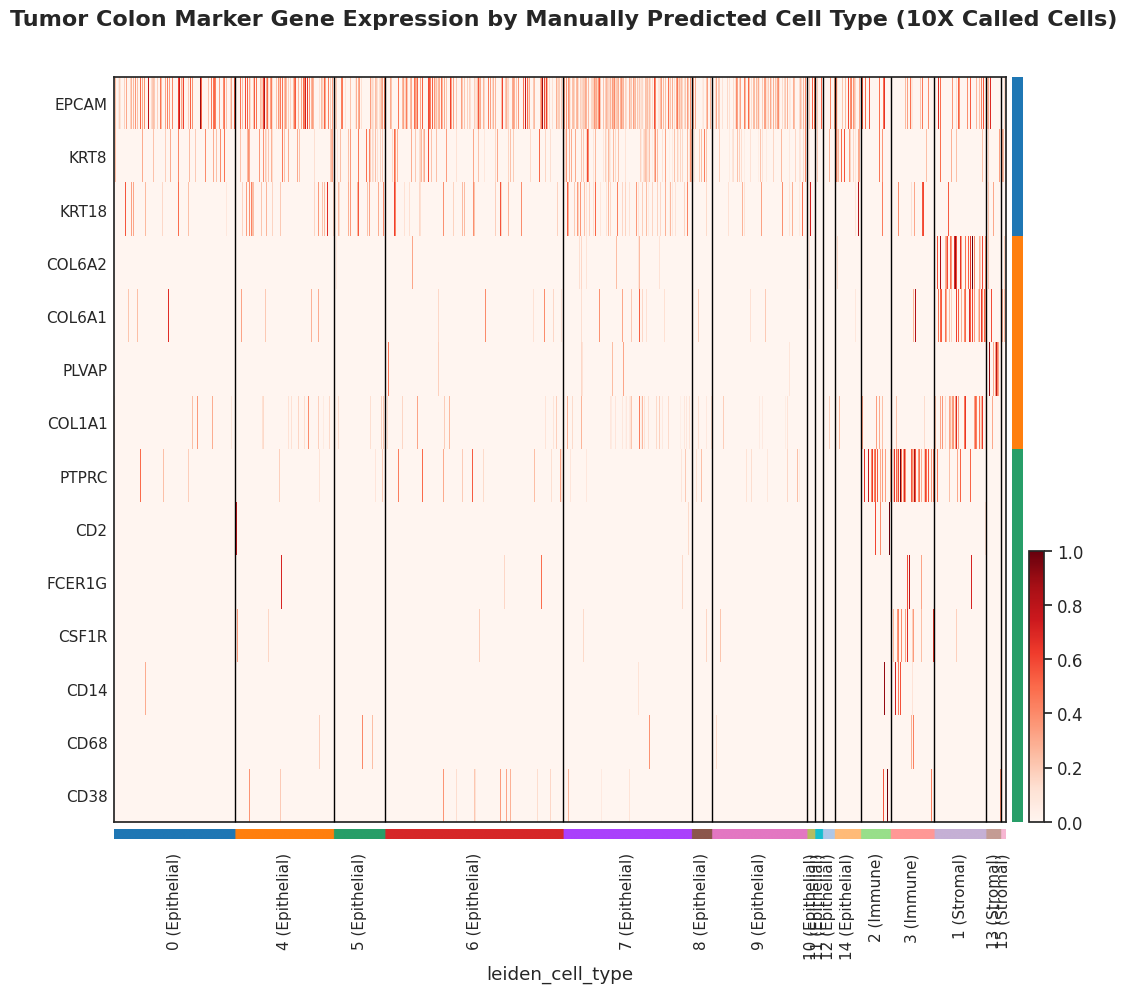

In [25]:
# Create and store the heatmap object
tumor_colon_hm = sc.pl.heatmap(
    tumor_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_labels=filtered_colon_marker_dict.keys(),
    var_group_rotation=45,
    dendrogram=False,
    figsize=(12, 10),
    show=False,
)

# Use any axis to get the figure
fig = next(iter(tumor_colon_hm.values())).figure

# Set suptitle and adjust layout
fig.suptitle(
    "Tumor Colon Marker Gene Expression by Manually Predicted Cell Type (10X Called Cells)",
    fontsize=16,
    weight="bold",
    y=0.94,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_marker_gene_heatmap.png"),
    bbox_inches="tight",
)

#### Plot Marker Gene Expression UMAPs

### Eptithelial

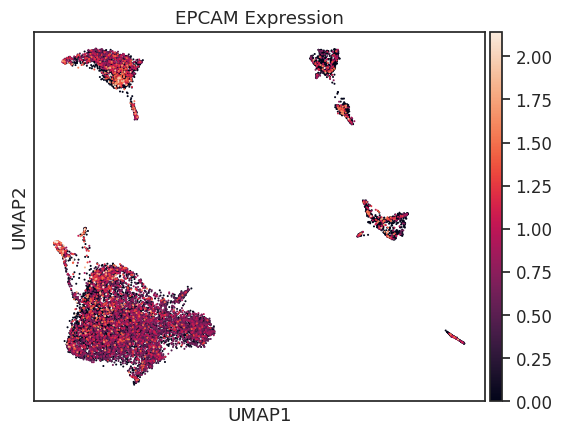

In [26]:
# Epithelial Marker (EPCAM)
sc.pl.umap(
    tumor_colon_adata,
    color="EPCAM",
    title="EPCAM Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

#### Immune

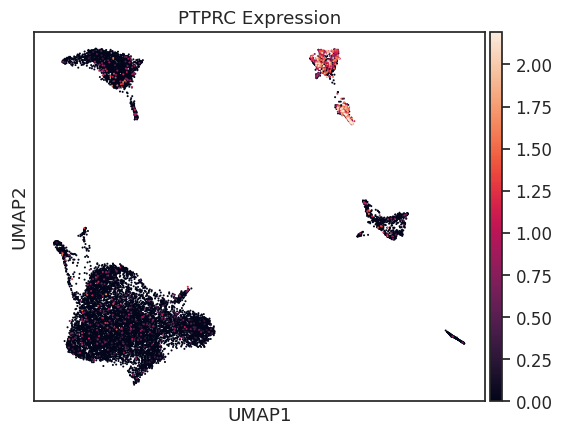

In [27]:
# Immune Marker (PTPRC)
sc.pl.umap(
    tumor_colon_adata,
    color="PTPRC",
    title="PTPRC Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

#### Stromal

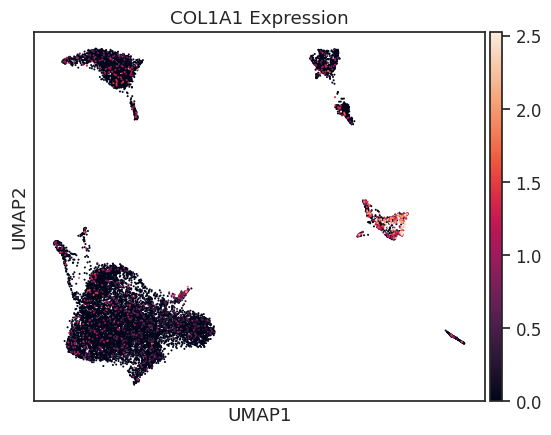

In [28]:
# Stromal Marker (COL1A1)
sc.pl.umap(
    tumor_colon_adata,
    color="COL1A1",
    title="COL1A1 Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

### Cancer/Stem Cell

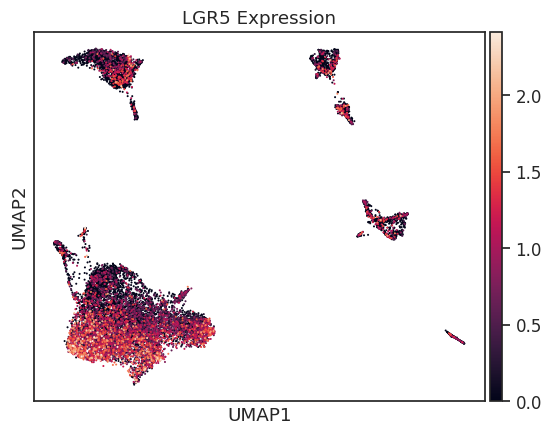

In [29]:
# Cancer/Stem Cell Like Marker (LGR5)
sc.pl.umap(
    tumor_colon_adata,
    color="LGR5",
    title="LGR5 Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

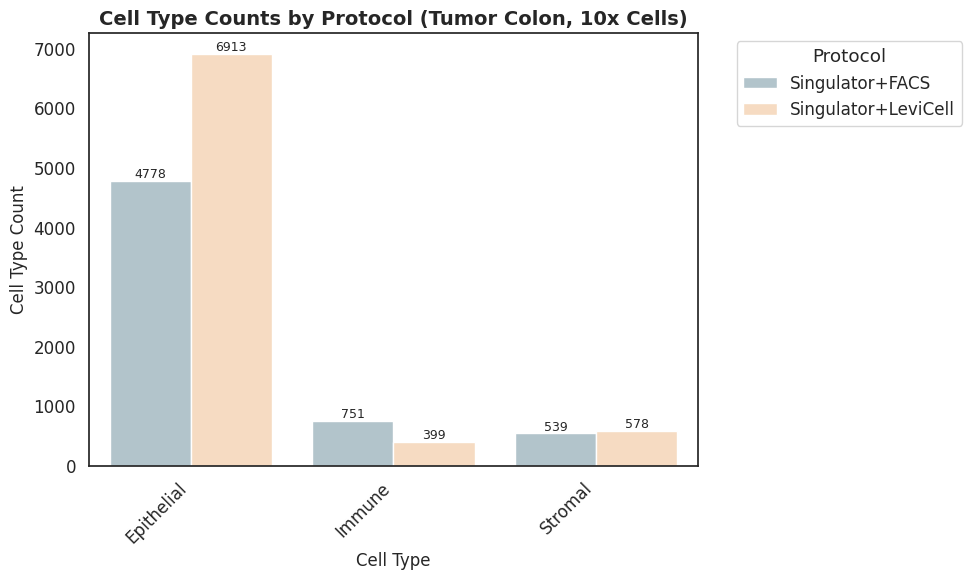

In [37]:
# Plot cell type proportions by protocol for Tumor Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=tumor_colon_adata,
    tissue="Tumor Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="predicted_cell_type",
    percentage=False,
    title="Cell Type Counts by Protocol (Tumor Colon, 10x Cells)"
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

### Tumor Colon InferCNV

In [30]:
import pandas as pd
import gzip


def parse_gtf_with_combined_lookup(gtf_path):
    """Parse GTF and return DataFrame with combined gene_id and gene_name indexing."""
    records = []
    with gzip.open(gtf_path, "rt") if gtf_path.endswith(".gz") else open(gtf_path) as f:
        for line in f:
            if line.startswith("#"):
                continue
            fields = line.strip().split("\t")
            if fields[2] != "gene":
                continue

            chrom, start, end, attributes = (
                fields[0],
                int(fields[3]),
                int(fields[4]),
                fields[8],
            )
            attr_dict = {
                k.strip(): v.strip('"')
                for attr in attributes.strip().split(";")
                if attr.strip()
                for k, v in [attr.strip().split(" ", 1)]
            }

            gene_id = attr_dict.get("gene_id")
            gene_name = attr_dict.get("gene_name")
            if gene_id and gene_name:
                records.append((gene_id, gene_name, chrom, start, end))

    df = pd.DataFrame(
        records, columns=["gene_id", "gene_name", "chromosome", "start", "end"]
    )

    # Two dataframes for matching
    by_id = df.drop_duplicates("gene_id").set_index("gene_id")
    by_name = df.drop_duplicates("gene_name").set_index("gene_name")

    # Merge on outer keys (index), prefer Ensembl ID matches but fill from gene symbol if missing
    combined = by_id.combine_first(by_name)

    return combined

In [31]:
gene_coords = parse_gtf_with_combined_lookup(os.path.join(GENE_SETS_DIR, GTF_FILE_NAME))

# Match to adata.var_names (can be mix of gene symbols and Ensembl IDs)
matched = gene_coords.reindex(tumor_colon_adata.var_names)

tumor_colon_adata.var["chromosome"] = "chr" + matched["chromosome"].fillna("NA").astype(
    str
)
tumor_colon_adata.var["start"] = matched["start"].astype("Int64")
tumor_colon_adata.var["end"] = matched["end"].astype("Int64")

In [32]:
# Define valid chromosomes: chr1 to chr23 (autosomes + chr23)
valid_chroms = {f"chr{i}" for i in range(1, 24)}

# Create mask for genes on valid chromosomes
valid_mask = tumor_colon_adata.var["chromosome"].isin(valid_chroms)

# Subset AnnData
tumor_colon_adata = tumor_colon_adata[:, valid_mask].copy()

In [33]:
cnv.tl.infercnv(
    tumor_colon_adata,
    reference_key="predicted_cell_type",
    reference_cat=["Immune", "Stromal"],
)

  0%|          | 0/3 [00:00<?, ?it/s]

Groups are not reordered because the `groupby` categories and the `var_group_labels` are different.
categories: 0 (Epithelial), 4 (Epithelial), 5 (Epithelial), etc.
var_group_labels: chr1, chr2, chr3, etc.


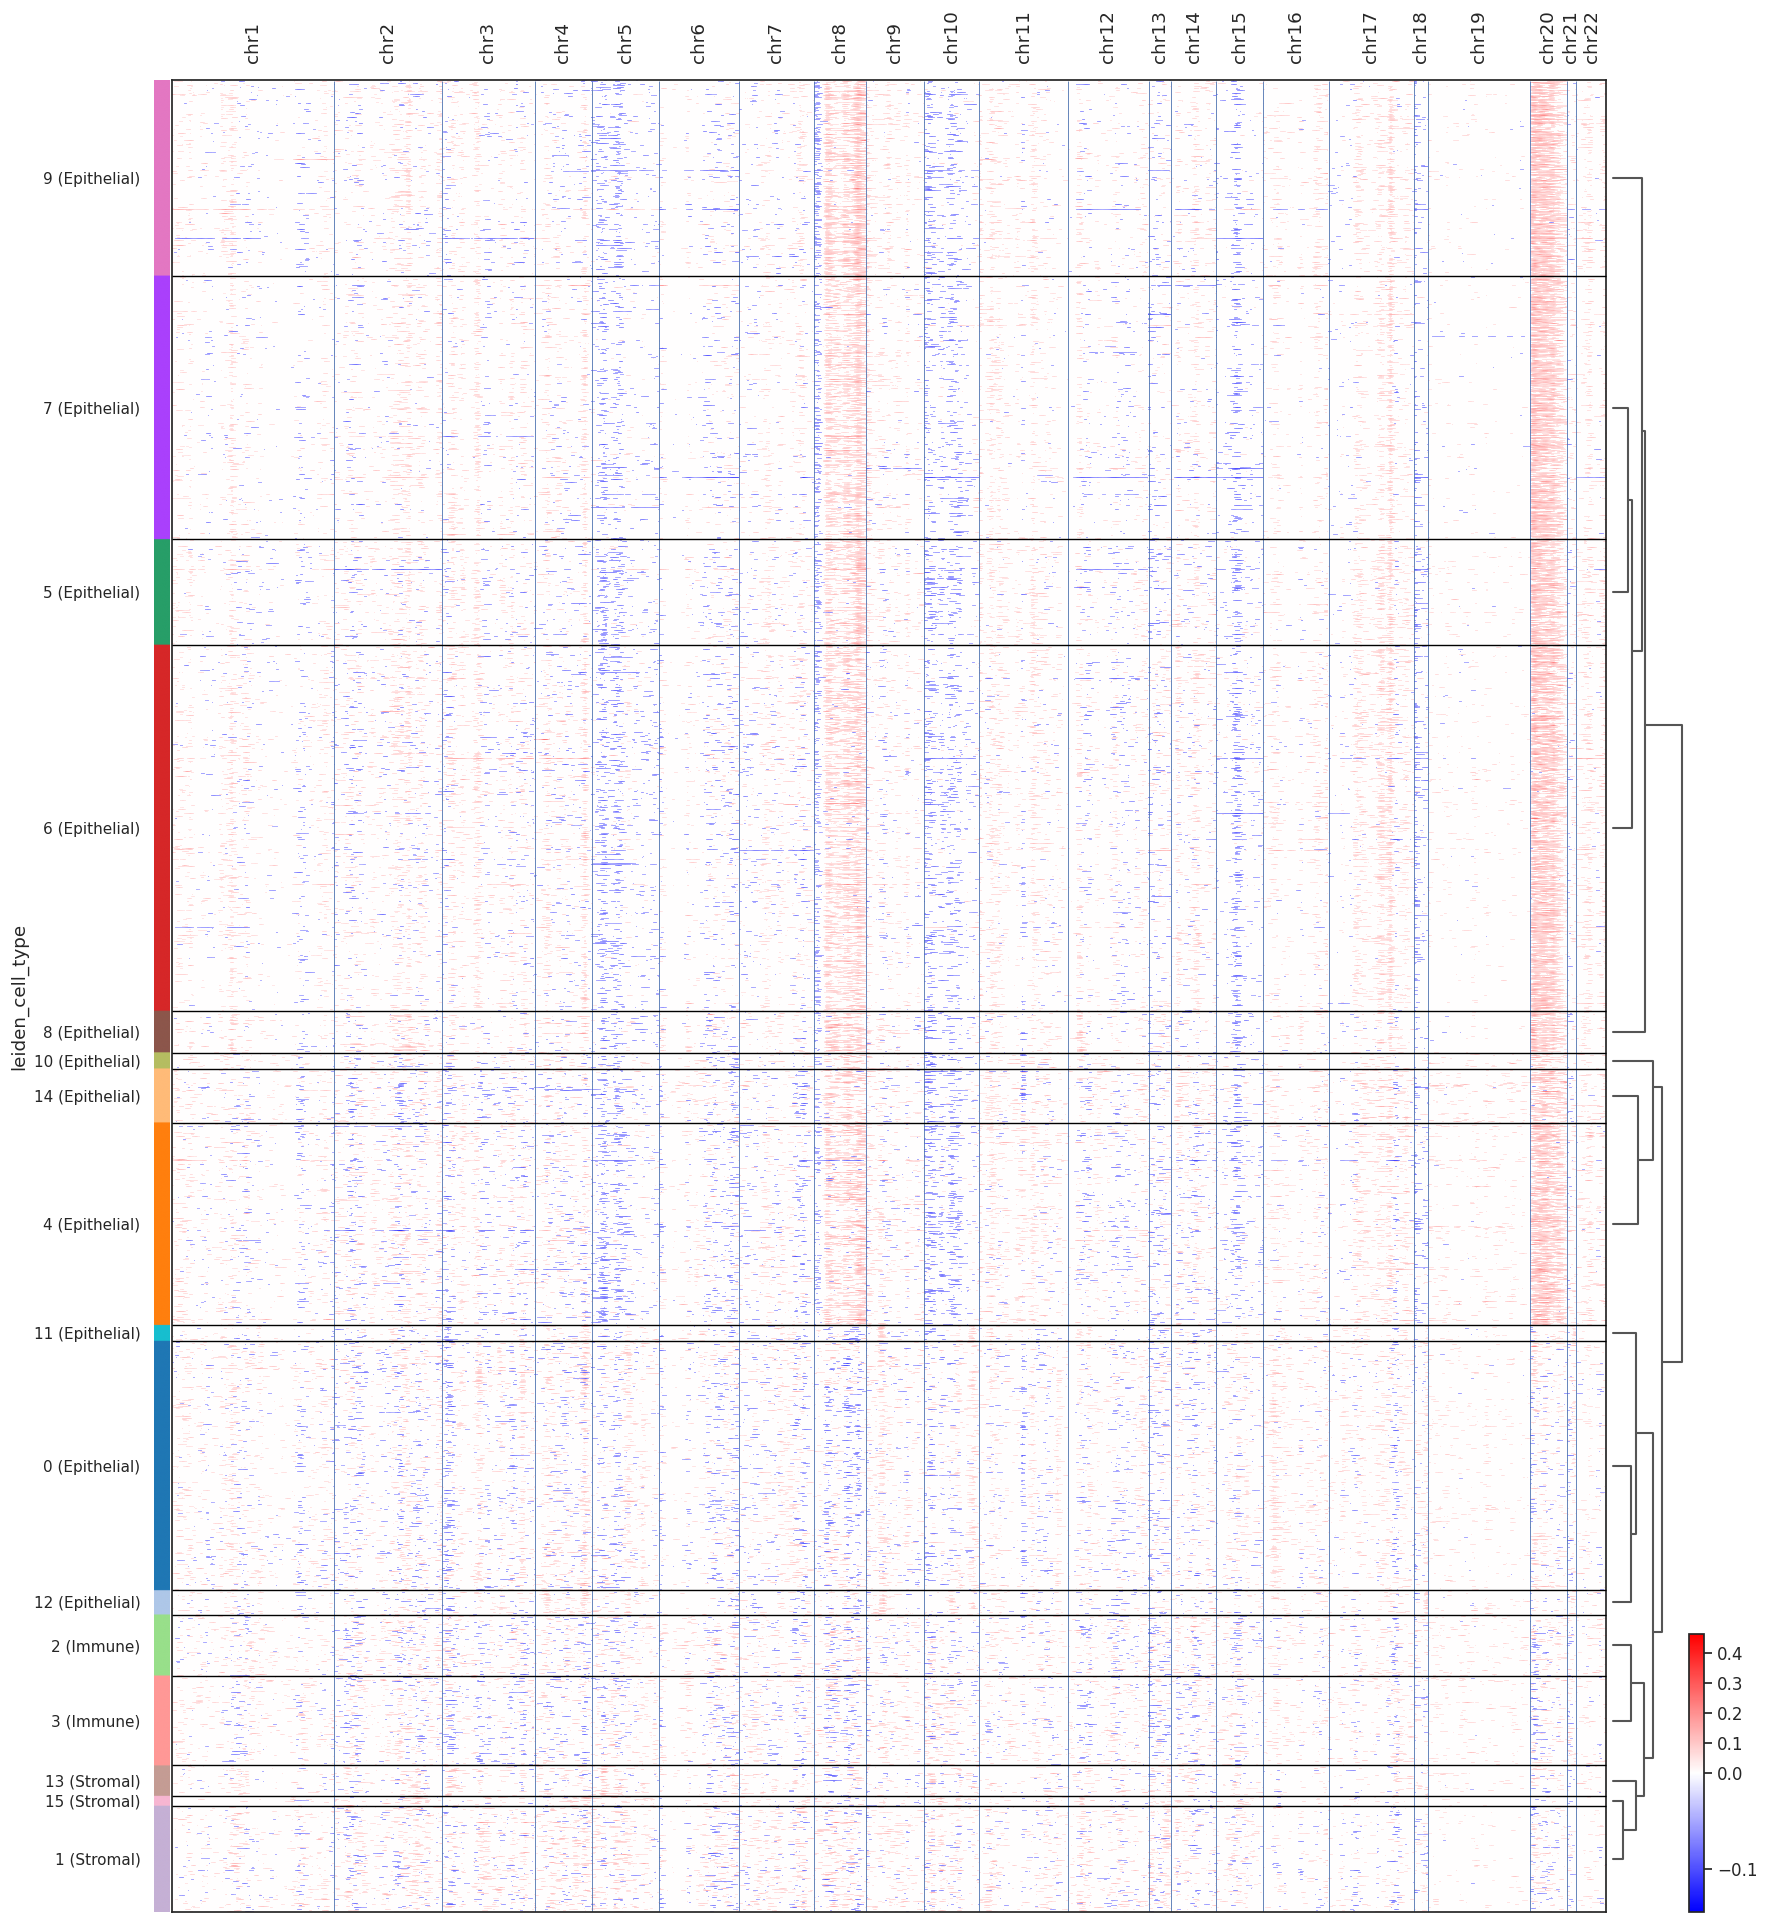

In [34]:
sc.tl.dendrogram(
    tumor_colon_adata,
    groupby="leiden_cell_type",
    optimal_ordering=True,
    inplace=True,
    use_raw=False,
)
cnv.pl.chromosome_heatmap(
    tumor_colon_adata, groupby="leiden_cell_type", figsize=(20, 24), dendrogram=True
)

In [35]:
cnv.tl.pca(tumor_colon_adata)
cnv.pp.neighbors(tumor_colon_adata)
cnv.tl.leiden(tumor_colon_adata)

KeyboardInterrupt: 

In [ ]:
cnv.tl.umap(tumor_colon_adata)
cnv.tl.cnv_score(tumor_colon_adata)

... storing 'chromosome' as categorical


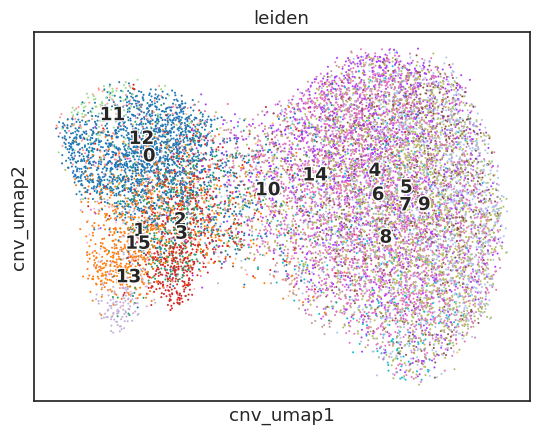

In [ ]:
cnv.pl.umap(
    tumor_colon_adata,
    color="leiden",
    legend_loc="on data",
    legend_fontoutline=2,
)
# cnv.pl.umap(tumor_colon_adata, color="cnv_score")
# cnv.pl.umap(tumor_colon_adata, color="predicted_cell_type")
# cnv.pl.umap(tumor_colon_adata, color="leiden")

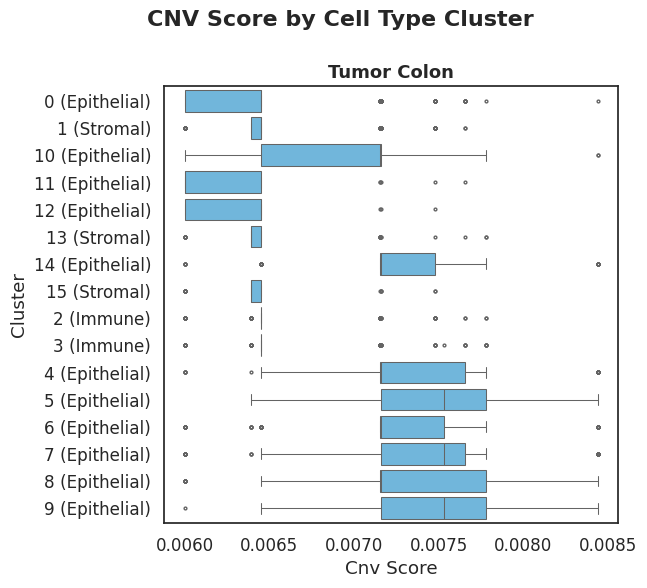

In [ ]:
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue={"Tumor Colon": tumor_colon_adata},
    cluster_key="leiden_cell_type",
    metric="cnv_score",
    vertical=True,
    title="CNV Score by Cell Type Cluster",
)

In [39]:
putative_tumor_clusters = ["0", "11", "12"]

# Start with predicted cell type
tumor_colon_adata.obs["putative_tumor"] = tumor_colon_adata.obs["predicted_cell_type"]
tumor_colon_adata.obs["putative_tumor"] = tumor_colon_adata.obs[
    "putative_tumor"
].astype(str)

# Boolean mask: Epithelial & in tumor clusters
mask = (tumor_colon_adata.obs["predicted_cell_type"] == "Epithelial") & (
    ~tumor_colon_adata.obs["leiden"].isin(putative_tumor_clusters)
)

# Append " (Tumor)" only where mask is True
tumor_colon_adata.obs.loc[mask, "putative_tumor"] = (
    tumor_colon_adata.obs.loc[mask, "putative_tumor"] + " (Tumor)"
)

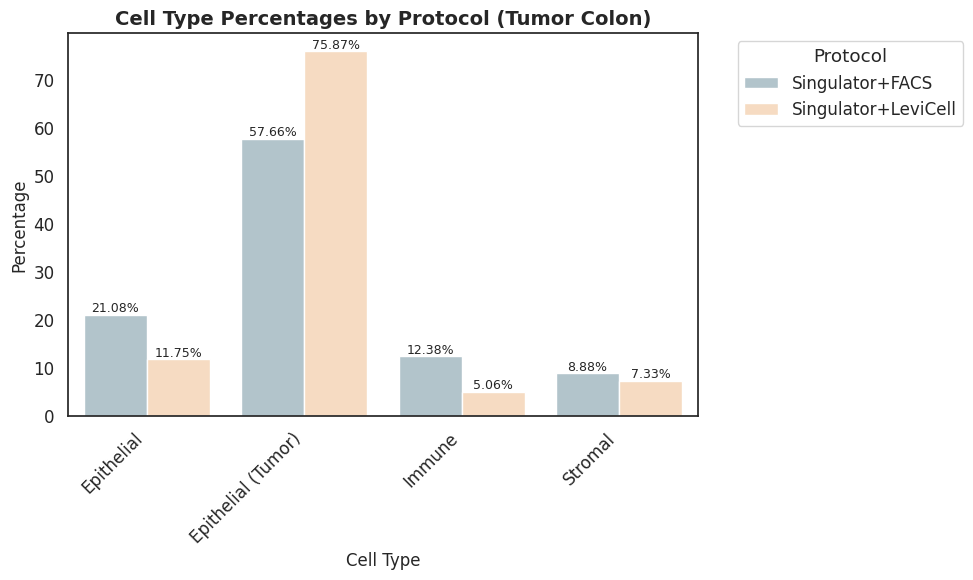

In [ ]:
# Plot cell type proportions by protocol for Tumor Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=tumor_colon_adata,
    tissue="Tumor Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="putative_tumor",
    percentage=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

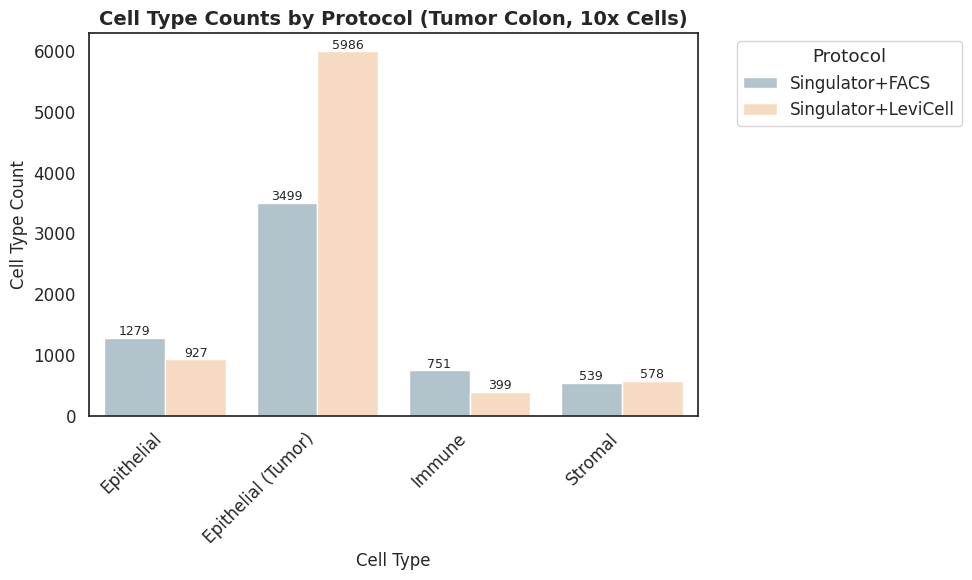

In [40]:
# Plot cell type proportions by protocol for Tumor Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=tumor_colon_adata,
    tissue="Tumor Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="putative_tumor",
    percentage=False,
    title="Cell Type Counts by Protocol (Tumor Colon, 10x Cells)"
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "tumor_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)